## Tarea 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

In [2]:
def viento(valor):
    norte = ['N', 'NNE', 'NNW']
    sur = ['S', 'SSE', 'SSW']
    este = ['E', 'ENE', 'ESE', 'NE', 'SE']
    oeste = ['W', 'WNW', 'WSW', 'NW', 'SW']

    if valor in norte:
        return 'N'
    elif valor in sur:
        return 'S'
    elif valor in este:
        return 'E'
    elif valor in oeste:
        return 'W'
    
def log(valor):
    e = 1
    valor = valor + e
    valor = np.log(valor)
    return valor

def no_valor(valor):
    if valor==0:
        return 1
    else:
        return 0
    
def bin(valor):
    if valor=='Yes':
        return 1
    else:
        return 0
    
def trimestre(valor):
    t1 = ['January', 'Febrary', 'March']
    t2 = ['April', 'May', 'June']
    t3 = ['July', 'August', 'September']
    t4 = ['October', 'November', 'December']
    if valor in t1:
        return 't1'
    elif valor in t2:
        return 't2'
    elif valor in t3:
        return 't3'
    else:
        return 't4'



In [3]:
df_original = pd.read_csv('../../data/machine_failure_data.csv', delimiter = ',', decimal = ',')
df_original.dtypes

Date                 object
Location              int64
Min_Temp             object
Max_Temp             object
Leakage              object
Evaporation          object
Electricity          object
Parameter1_Dir       object
Parameter1_Speed    float64
Parameter2_9am       object
Parameter2_3pm       object
Parameter3_9am      float64
Parameter3_3pm      float64
Parameter4_9am      float64
Parameter4_3pm      float64
Parameter5_9am       object
Parameter5_3pm       object
Parameter6_9am      float64
Parameter6_3pm      float64
Parameter7_9am       object
Parameter7_3pm       object
Failure_today        object
dtype: object

## Limpieza de Datos

In [4]:
df = df_original

# Se elimina el Parámetro 6 que contiene muy pocos valores

df = df.drop('Parameter6_9am', axis=1)
df = df.drop('Parameter6_3pm', axis=1)

# Aplicamos el cuadrante en la dirección del viento

df['Parameter1_Dir'] = df['Parameter1_Dir'].apply(viento)
df['Parameter2_3pm'] = df['Parameter2_3pm'].apply(viento)
df['Parameter2_9am'] = df['Parameter2_9am'].apply(viento)

# Estandarizamos el Parámetro 5

df['Parameter5_9am'] = pd.to_numeric(df['Parameter5_9am'], errors='coerce')
df['Parameter5_3pm'] = pd.to_numeric(df['Parameter5_3pm'], errors='coerce')
df = df.dropna(subset=['Parameter5_9am'])
df = df.dropna(subset=['Parameter5_3pm'])

mp5_9 = np.mean(df['Parameter5_9am'])
mp5_3 = np.mean(df['Parameter5_3pm'])
sp5_9 = np.std(df['Parameter5_9am'])
sp5_3 = np.std(df['Parameter5_3pm'])

df['Parameter5_9am'] = (df['Parameter5_9am'] - mp5_9) / sp5_9
df['Parameter5_3pm'] = (df['Parameter5_3pm'] - mp5_3) / sp5_3

# Sumamos un e = 1 a todos los valores de Leakage y aplicamos Log

df['Leakage'] = pd.to_numeric(df['Leakage'], errors='coerce')
df = df.dropna(subset=['Leakage'])

df['Leakage'] = df['Leakage'].apply(log)

# Trabajamos la variable Evaporation y Electricity

df['Evaporation'] = pd.to_numeric(df['Evaporation'])
df['Electricity'] = pd.to_numeric(df['Electricity'])

df['Evaporation'] = df['Evaporation'].fillna(0)
df['Electricity'] = df['Electricity'].fillna(0)

df['No_Evaporation'] = df['Evaporation'].apply(no_valor)
df['No_Electricity'] = df['Electricity'].apply(no_valor)

# Trabajamos Failure

df['Failure_today'] = df['Failure_today'].apply(bin)

# Hacemos una columna con los Meses

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month_name()

# Cambio de Nombres

df.rename(columns = {'Parameter1_Dir':'Dir_Viento',
                     'Parameter1_Speed':'Vel_Viento', 
                     'Parameter2_9am':'Dir_Mañana', 
                     'Parameter2_3pm':'Dir_Tarde',
                     'Parameter7_9am':'Temp_Mañana',
                     'Parameter7_3pm':'Temp_Tarde',
                     'Parameter3_9am':'Vel_Mañana',
                     'Parameter3_3pm':'Vel_Tarde'
                     },
                     inplace=True)

# Se limpian las Temperaturas de Mañana y Tarde

df = df.dropna(subset=['Temp_Mañana'])
df = df.dropna(subset=['Temp_Tarde'])
df['Temp_Mañana'] = pd.to_numeric(df['Temp_Mañana'], errors='coerce')
df['Temp_Tarde'] = pd.to_numeric(df['Temp_Tarde'], errors='coerce')

# Filtramos los datos desde 2009 en adelante

df = df[df['Date'].dt.year >= 2009]

# Hacemos Dummies las variables categóricas

dummie = pd.get_dummies(df, columns=['Dir_Mañana', 'Dir_Tarde', 'Dir_Viento','Month'])
dummie = dummie.replace({True: 1, False:0})

# Aplicar columna con Trimestres

df['Trimestre'] = df['Month'].apply(trimestre)

# Limpiar Temp Máximas y Mínimas

df = df.dropna(subset=['Min_Temp'])
df = df.dropna(subset=['Max_Temp'])
df['Min_Temp'] = pd.to_numeric(df['Min_Temp'], errors='coerce')
df['Max_Temp'] = pd.to_numeric(df['Max_Temp'], errors='coerce')

# Limpiamos datos que no estan 

df = df.dropna(subset=['Dir_Viento'])
df = df.dropna(subset=['Vel_Viento'])
df = df.dropna(subset=['Dir_Mañana'])
df = df.dropna(subset=['Dir_Tarde'])
df = df.dropna(subset=['Vel_Mañana'])
df = df.dropna(subset=['Vel_Tarde'])
df = df.dropna(subset=['Parameter4_9am'])
df = df.dropna(subset=['Parameter4_3pm'])

df.head(10)

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Dir_Viento,Vel_Viento,Dir_Mañana,...,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Temp_Mañana,Temp_Tarde,Failure_today,No_Evaporation,No_Electricity,Month,Trimestre
30,2009-01-01,3,11.3,26.5,0.0,0.0,0.0,W,56.0,W,...,26.0,-1.851431,-1.713335,19.7,25.7,0,1,1,January,t1
31,2009-01-02,3,9.6,23.9,0.0,0.0,0.0,W,41.0,W,...,22.0,-0.458103,-0.306563,14.9,22.1,0,1,1,January,t1
32,2009-01-03,3,10.5,28.8,0.0,0.0,0.0,S,26.0,S,...,22.0,0.147080,-0.064995,17.1,26.5,0,1,1,January,t1
33,2009-01-04,3,12.3,34.6,0.0,0.0,0.0,W,37.0,S,...,12.0,-0.359584,-0.704438,20.7,33.9,0,1,1,January,t1
34,2009-01-05,3,12.9,35.8,0.0,0.0,0.0,W,41.0,E,...,9.0,-0.711435,-0.860746,22.4,34.4,0,1,1,January,t1
35,2009-01-06,3,13.7,37.9,0.0,0.0,0.0,W,52.0,E,...,8.0,-0.950693,-1.215991,23.1,36.8,0,1,1,January,t1
36,2009-01-07,3,16.1,38.9,0.0,0.0,0.0,W,57.0,E,...,12.0,-1.499580,-1.784385,25.2,38.4,0,1,1,January,t1
37,2009-01-08,3,14.0,28.3,0.0,0.0,0.0,W,48.0,W,...,15.0,-0.809953,-0.619179,17.9,27.6,0,1,1,January,t1
38,2009-01-09,3,12.5,28.4,0.0,0.0,0.0,E,37.0,S,...,16.0,0.020414,-0.221304,17.2,26.6,0,1,1,January,t1
39,2009-01-10,3,17.0,30.8,0.0,0.0,0.0,E,37.0,N,...,24.0,-0.598843,-1.017054,20.2,29.3,0,1,1,January,t1


Lo siguiente es para ver cuantos valores tienen las columnas de Electricity y Evaporation para ver si es bueno hacer variables indicadoras

In [5]:
df['Elec'] = df['No_Electricity'].apply(no_valor)
df['Evap'] = df['No_Evaporation'].apply(no_valor)

group = df.groupby(['Location']).agg({
    'Elec': 'sum',
    'Evap': 'sum'
}).reset_index()

group.head(10)

no_elec = group[group['Elec'] == 0]['Location'].unique()
no_evap = group[group['Evap'] == 0]['Location'].unique()

total = len(df['Elec'])
sum_elec = np.sum(group['Elec'])
sum_evap = np.sum(group['Evap'])
p_elec = round((sum_elec/total)*100,2)
p_evap = round((sum_evap/total)*100,2)

print(f'Los sensores que no tienen valores en Electricity son: {no_elec}.\nLos sensore que no tienen valores en Evaporation son: {no_evap}')
print(f'El {p_elec}% de los datos tienen valores en Electricity\nEl {p_evap}% de los datos tienen valores en Evaporation')


Los sensores que no tienen valores en Electricity son: [ 3  5  6  7 15 17 18 26 27 35 41 42 44 47 48].
Los sensore que no tienen valores en Evaporation son: [ 3  5  6 15 26 27 30 41 42 44 47 48]
El 56.81% de los datos tienen valores en Electricity
El 63.02% de los datos tienen valores en Evaporation


<Axes: >

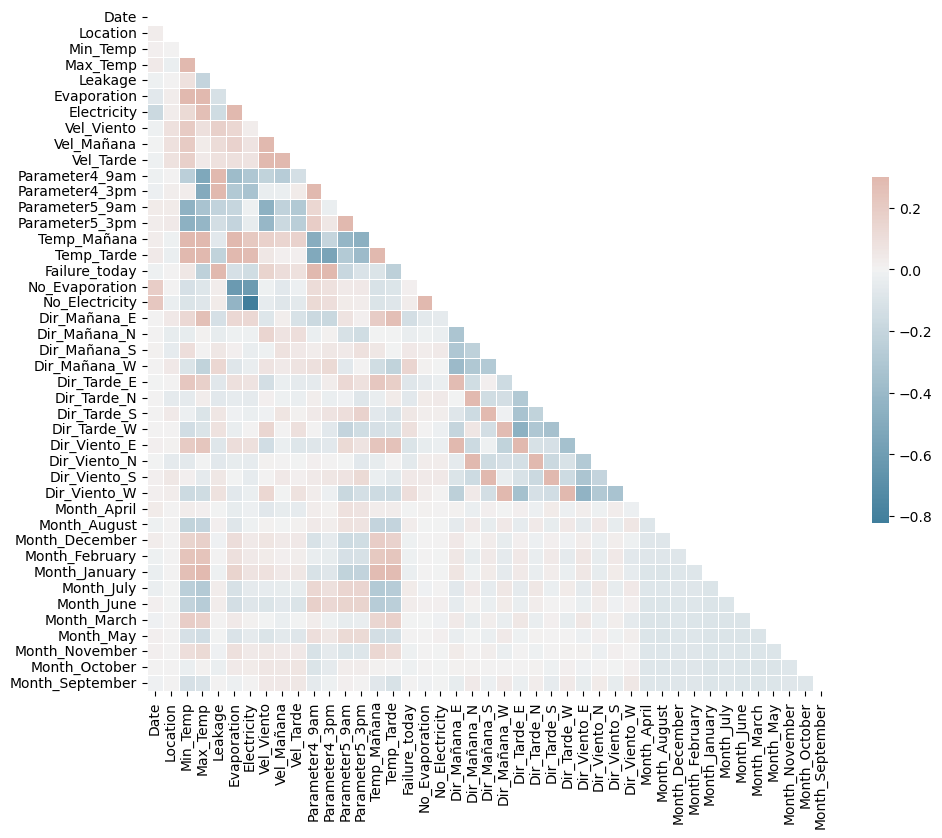

In [6]:
corr = dummie.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:** La variables 'Parameter4_9am', 'Parameter4_3pm' y 'Leakage' tienen mucha covariación con la variable dependiente por lo que las excluimos del modelo

Además,

- Se excluye la variable 'Vel_Tarde' porque tiene mucha correlación con 'Vel_Mañana' por lo que probablemente expliquen lo mismo
- Se excluye la variable 'Parameter5_3pm' porque tiene mucha correlación con 'Parameter5_9am' por lo que probablemente expliquen lo mismo

Luego, se puede ver que hay variables categóricas que no son significativas, sobre todo las del ID del sensor (Location), esto se puede deber a que existían muchas celdas que no tenían valores, por lo que no aporta de tan buena forma a la regresión.

Además, se hicieron interacciones entre las variables de velocidad y dirección del viento pero no se llegó a nada bueno por lo que se decidió dejar las variables de forma lineal.


## OLS

In [7]:
ols = smf.ols("Failure_today ~ C(Dir_Mañana, Treatment(reference='N')) + Vel_Mañana + C(Dir_Tarde, Treatment(reference='N')) + No_Electricity + Min_Temp + Temp_Mañana + Temp_Tarde + C(Location) + C(Trimestre, Treatment(reference='t2')) + Parameter5_9am + Evaporation + No_Evaporation + Electricity + No_Electricity", 
                data=df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     539.2
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:38:42   Log-Likelihood:                -46188.
No. Observations:              111179   AIC:                         9.250e+04
Df Residuals:                  111117   BIC:                         9.310e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R**: Corriendo el mismo modelo anterior en Probit, se logró una mejor explicación de los datos.

Además, se puede ver que practicamente las mismas variables categóricas del ID del sensor no son significativa por lo que podemos suponer lo mismo que se concluyó anteriormente. 

Un cambio importante es que la variable No_Electricity que es una variable indicadora (1 si no hay datos en Electricity) no es significativa, lo que puede deberse a que tiene alta correlación con la variable No_Evaporation o porque en este modelo no aporta información relevante

## Probit

In [8]:
probit = smf.probit("Failure_today ~ C(Dir_Mañana, Treatment(reference='N')) + Vel_Mañana + C(Dir_Tarde, Treatment(reference='N')) + No_Electricity + Min_Temp + Temp_Mañana + Temp_Tarde + C(Location) + C(Trimestre, Treatment(reference='t2')) + Parameter5_9am + Evaporation + No_Evaporation + Electricity + No_Electricity", 
                data=df).fit()
print(probit.summary())

Optimization terminated successfully.
         Current function value: 0.394917
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               111179
Model:                         Probit   Df Residuals:                   111117
Method:                           MLE   Df Model:                           61
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2587
Time:                        21:38:46   Log-Likelihood:                -43907.
converged:                       True   LL-Null:                       -59226.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                             

4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R** Corriendo el modelo anterior, podemos obtener resultados muy parecidos a los anteriores en temas de significancia de las variables, pero este modelo explica mejor la data.

En este caso, nuevamente las variables categóricas de Location no son significativas y la variable No_Electricity, lo que puede deberse a lo explicado en el punto anterior.

## Logit

In [9]:
logit = smf.logit("Failure_today ~ C(Dir_Mañana, Treatment(reference='N')) + Vel_Mañana + C(Dir_Tarde, Treatment(reference='N')) + No_Electricity + Min_Temp + Temp_Mañana + Temp_Tarde + C(Location) + C(Trimestre, Treatment(reference='t2')) + Parameter5_9am + Evaporation + No_Evaporation + Electricity + No_Electricity", 
                data=df).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.393421
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               111179
Model:                          Logit   Df Residuals:                   111117
Method:                           MLE   Df Model:                           61
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2615
Time:                        21:38:50   Log-Likelihood:                -43740.
converged:                       True   LL-Null:                       -59226.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                             

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Según los resultados, OLS explica poco de la regresión y no lo explica como uno esperaria ya que solo toma valores continuos y puede entregar erroneamente valores binarios. Por otro lado, logit y probit son mejores en este caso, ya que explican una probabilidad, lo que favorece en este modelo porque la variable que queremos explicar es binaria. 

Como Logit explica mejor el modelo, podemos decir que es la mejor opción para explicar las Fallas.

Además, muchas de las variables son robustas exceptuando:

- C(Dir_Mañana)[E]	No significativa en Logit ni Probit (p > 0.5).
- C(Location)[T.11]	No significativa en Logit ni Probit.
- C(Location)[T.13]	No significativa en Logit, débil en Probit.
- C(Location)[T.18]	Marginal en Logit (p = 0.053), no robusta.
- C(Location)[T.28]	No significativa (p = 0.830).
- C(Location)[T.29]	No significativa (p = 0.547).
- C(Location)[T.34]	No significativa (p = 0.721).
- C(Location)[T.38]	No significativa (p = 0.189).
- C(Location)[T.41]	No significativa (p = 0.836).
- C(Location)[T.42]	No significativa (p = 0.734).
- C(Location)[T.43]	Marginal (p = 0.053), no robusta.
- C(Location)[T.44]	No significativa (p = 0.245).
- No_Electricity	No significativa en Logit (p = 0.197), débil en otros.
- C(Trimestre)[T.t3] Muy débil en Logit (p = 0.039), no siempre aparece significativa en OLS.

Y hay algunas con comportamientos dudosos como:

- Electricity
- No_Evaporation
- Vel_Mañana

## Poisson

6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

Para hacer el modelo de Poisson, hacemos un nuevo df con los valores por mes en promedio y sin considerar las variables categóricas. En este caso, trabajaremos con,

1. Velocidad (Mañana y Tarde)
2. Parameter4 (Mañana y Tarde) 
3. Parameter5 (Mañana y Tarde)
4. Temperatura (Mañana y Tarde)
5. Temperatura (Máxima y Mínima)
6. Location 

Se decidió excluir las variables Evaporation y Electricity y sus respectivos indicadores porque tenían muy pocos datos, lo que no favorece a este tipo de análisis. 

In [10]:
df['Periodo'] = df['Date'].dt.to_period('M')
df_mensual = df.groupby(['Periodo','Location']).agg({
    'Failure_today' : 'sum',
    'Vel_Mañana' : 'mean',
    'Vel_Tarde' : 'mean',
    'Temp_Mañana' : 'mean',
    'Temp_Tarde' : 'mean',
    'Max_Temp' : 'mean',
    'Min_Temp' : 'mean',
    'Parameter4_9am' : 'mean',
    'Parameter4_3pm' : 'mean',
    'Parameter5_9am' : 'mean',
    'Parameter5_3pm' : 'mean'
}).reset_index()

df_mensual.head(10)

,Periodo,Location,Failure_today,Vel_Mañana,Vel_Tarde,Temp_Mañana,Temp_Tarde,Max_Temp,Min_Temp,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm
0,2009-01,1,0,10.448276,17.931034,23.510345,30.579310,31.868966,17.975862,38.689655,23.827586,-0.468294,-0.416811
1,2009-01,3,1,11.935484,18.548387,22.993548,32.964516,34.658065,16.312903,41.903226,17.870968,-0.646059,-0.779612
2,2009-01,4,3,18.516129,25.032258,29.241935,34.487097,36.058065,22.422581,37.096774,24.516129,-1.293918,-1.495604
3,2009-01,5,3,7.551724,17.758621,22.524138,31.279310,32.872414,16.455172,65.724138,36.206897,-0.294553,-0.444251
4,2009-01,6,0,20.172414,22.241379,18.637931,26.589655,28.548276,10.617241,50.586207,24.379310,-0.682316,-0.540780
5,2009-01,7,0,14.645161,20.645161,21.087097,31.338710,32.864516,13.125806,42.096774,14.064516,-0.642881,-0.648515
6,2009-01,8,6,10.857143,16.964286,26.721429,28.114286,30.207143,21.285714,63.035714,56.000000,-0.424928,-0.361372
7,2009-01,9,17,11.933333,14.733333,27.653333,29.336667,30.906667,24.030000,77.500000,71.566667,-1.289877,-1.370405
8,2009-01,10,4,10.322581,19.161290,20.083871,29.322581,31.022581,14.003226,57.903226,26.516129,-0.477171,-0.599468
9,2009-01,11,3,17.233333,14.600000,27.073333,34.420000,36.623333,22.203333,37.866667,19.900000,-0.774299,-0.802012


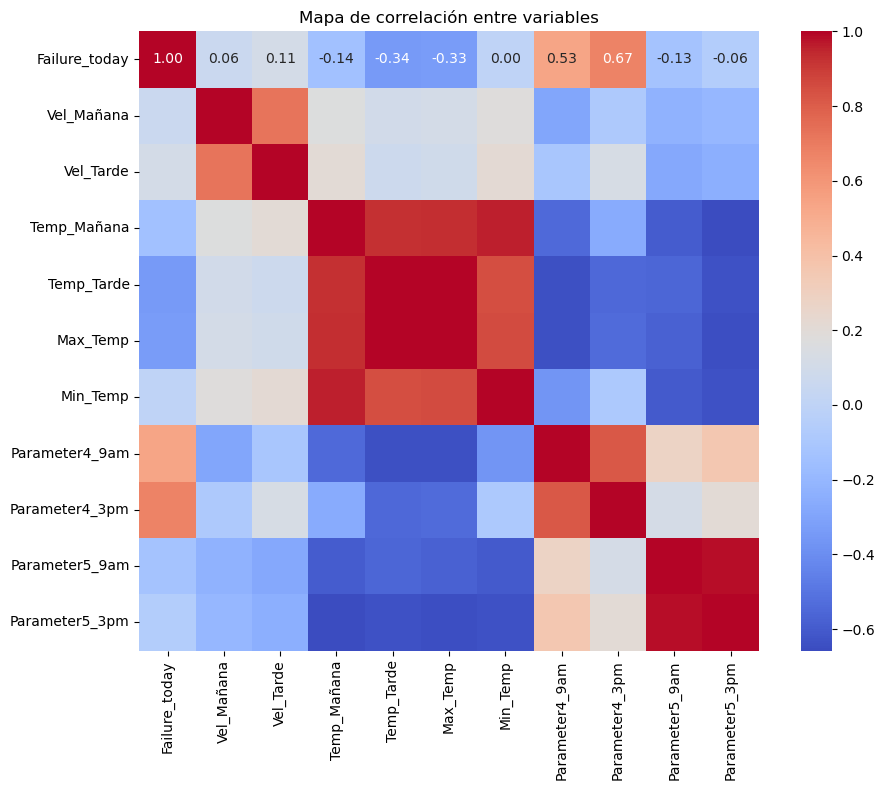

In [11]:
df_corr = df_mensual.drop(columns=['Location','Periodo'])

corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Mapa de correlación entre variables")
plt.tight_layout()
plt.show()

(array([ 822.,  846., 1086.,  522.,  466.,  148.,  127.,   27.,   26.,
           6.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <BarContainer object of 10 artists>)

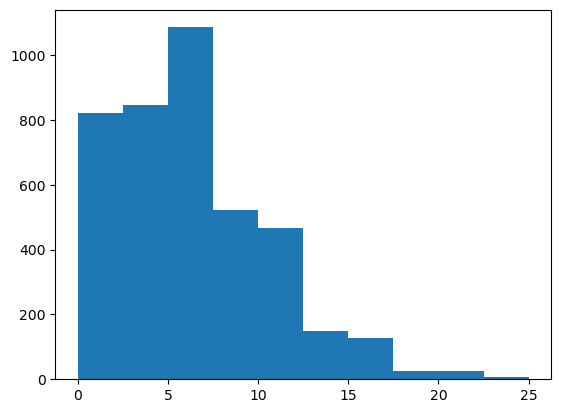

In [12]:
plt.hist(df_mensual.Failure_today)

**R**: De la correlación, se decidió excluir el Parameter4_3pm y Parameter5_3pm porque estaban muy correlacionados con el mismo parámetro pero en tomado en la tarde. Lo mismo pasa con las variables de Temp_Mañana y Min_Temp, y con Temp_Tarde y Max_Temp, por lo que solo dejamos las variables Temp_Mañana y Temp_Tarde.

Así, se formó la regresión viendo que la mayoría de las variables son significativas, exceptuando algunas ubicaciones del sensor.

In [13]:
poisson = smf.poisson('Failure_today ~ Vel_Mañana + Temp_Mañana + Temp_Tarde + C(Location) + Parameter4_9am + Parameter5_9am',
                       data=df_mensual).fit()
print(poisson.summary())

Optimization terminated successfully.
         Current function value: 2.288684
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:          Failure_today   No. Observations:                 4076
Model:                        Poisson   Df Residuals:                     4027
Method:                           MLE   Df Model:                           48
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2856
Time:                        21:38:51   Log-Likelihood:                -9328.7
converged:                       True   LL-Null:                       -13059.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0423      0.123      0.344      0.731      -0.199       0.283
C(Locati

7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

**R**: De aquí podemos suponer que hay sobredispersión en la data y que el valor de Alpha será de aproximadamente 1.03

In [14]:
y = df_mensual['Failure_today']
mu = poisson.predict()
aux=((y-mu)**2-mu)/mu
auxr=sm.OLS(aux,mu).fit()
print(auxr.summary())

                                 OLS Regression Results                                
Dep. Variable:          Failure_today   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              22.37
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                    2.33e-06
Time:                        21:38:51   Log-Likelihood:                         -7644.9
No. Observations:                4076   AIC:                                  1.529e+04
Df Residuals:                    4075   BIC:                                  1.530e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
alpha = np.exp(0.0273)
print(f'El valor esperado de Alpha será {alpha} y se puede ver que hay sobredispersión')

El valor esperado de Alpha será 1.027676059340493 y se puede ver que hay sobredispersión


8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R**: Aplicando la regresión definida anterior con el modelo de Binomial Negativa, se puede ver que se obtuvo un Alpha practicamente igual de 1.03. 

Además, las variables tienen la misma significancia que en el modelo Poisson. 

Del modelo también se puede ver que la ubicación del sensor aporta mucho a la probabilidad de una falla, al igual que la Temperatura y el Parameter5.

## Binomial Negativa

In [16]:
nbin = smf.negativebinomial('Failure_today ~ Vel_Mañana  + Temp_Mañana + Temp_Tarde + C(Location) + Parameter4_9am + Parameter5_9am'
                            , data=df_mensual).fit()
print(nbin.summary())

         Current function value: 2.285015
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
                     NegativeBinomial Regression Results                      
Dep. Variable:          Failure_today   No. Observations:                 4076
Model:               NegativeBinomial   Df Residuals:                     4027
Method:                           MLE   Df Model:                           48
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.1748
Time:                        21:38:52   Log-Likelihood:                -9313.7
converged:                      False   LL-Null:                       -11287.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0129      0.132     -0.097      0.923 

In [17]:
alpha = np.exp(0.0328)

print(f'El valor que toma alpha es de {alpha}')

El valor que toma alpha es de 1.03334384980309


9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Ambos modelos son para data de conteo. El de poisson es bueno bajo el supuesto que la varianza ~ media (no hay sobredispersion), mientras que el modelo binomial negativa es bueno cuando si existe sobredispersion (varianza >> media). 

Bajo lo anterior, se puede decir que el modelo de binomial negativa es mejor, ya que existe sobredispersion. Además, tiene una mejor estimación de la Log-Likelihood (muy poca deferencia).

Podemos concluir que todas las variables son robustas (mismo signo y significativas) exceptuando las categóricas:

- T.4
- T.33
- T.42